In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scglue
import anndata as ad

import matplotlib as mpl
from matplotlib import cm
from matplotlib import pyplot as plt
import seaborn as sns
import os
from itertools import cycle

%matplotlib inline

sns.set_style('ticks')
mpl.rcParams['figure.figsize'] = [4, 4]
mpl.rcParams['figure.dpi'] = 100

sc.set_figure_params(figsize=(10,10),dpi=120)

In [2]:
path = '/lustre/scratch/kiviaho/spatac/integrations/multiome_5k/single_cell_all/results'
os.chdir(path)

In [3]:
# DOWNLOAD DATA
rna = sc.read_h5ad('rna-20221121-with-glue-embeddings.h5ad')
atac = sc.read_h5ad('atac-20221121-with-glue-embeddings.h5ad')
glue = scglue.models.load_model('glue-model-20221121.dill')

# Add common column key to plot with
rna.obs['SEACell_id'] = rna.obs['ATAC_SEACell_id']
rna.obs['domain'] = 'rna'
atac.obs['domain'] = 'atac'

[INFO] autodevice: Using CPU as computation device.


In [4]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)
combined = ad.concat([rna, atac])
combined.obs['SEACell_id'] = combined.obs['SEACell_id'].astype('category')

/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/merge.py:555: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  dfs = [df.reindex(index=new_index) for df in dfs]
/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


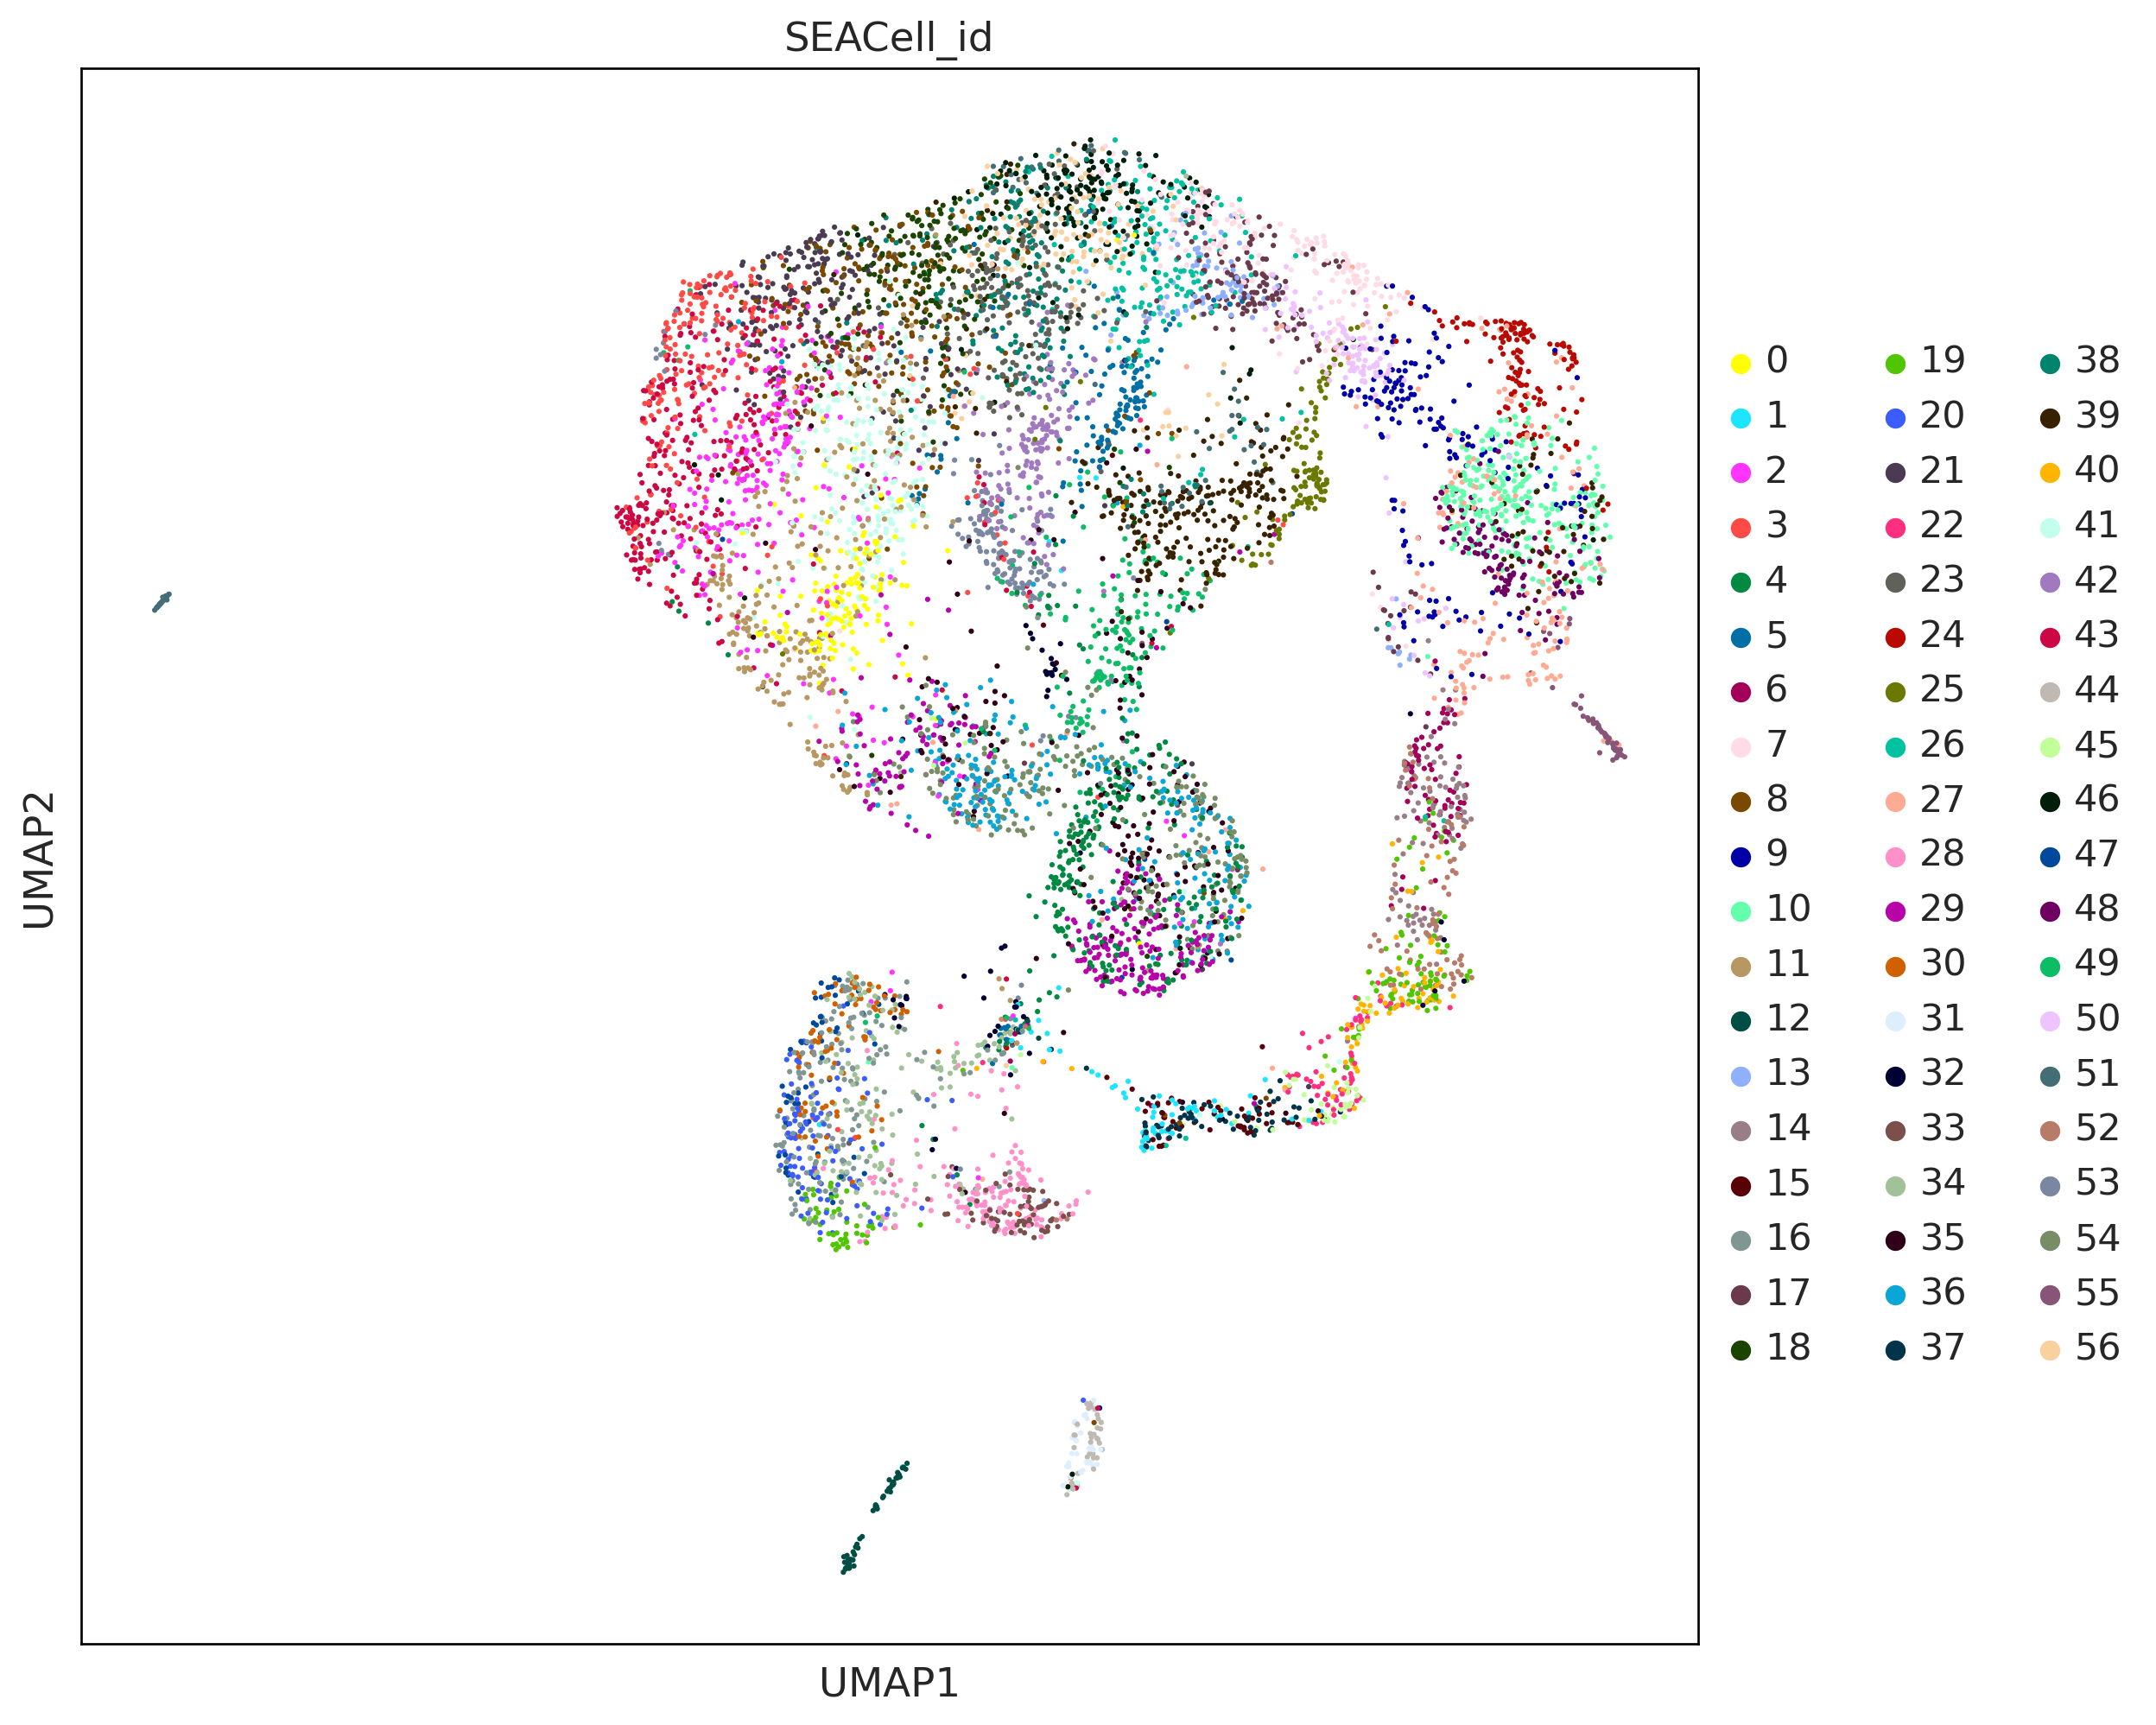

In [6]:
sc.pl.umap(combined, color=["SEACell_id"])

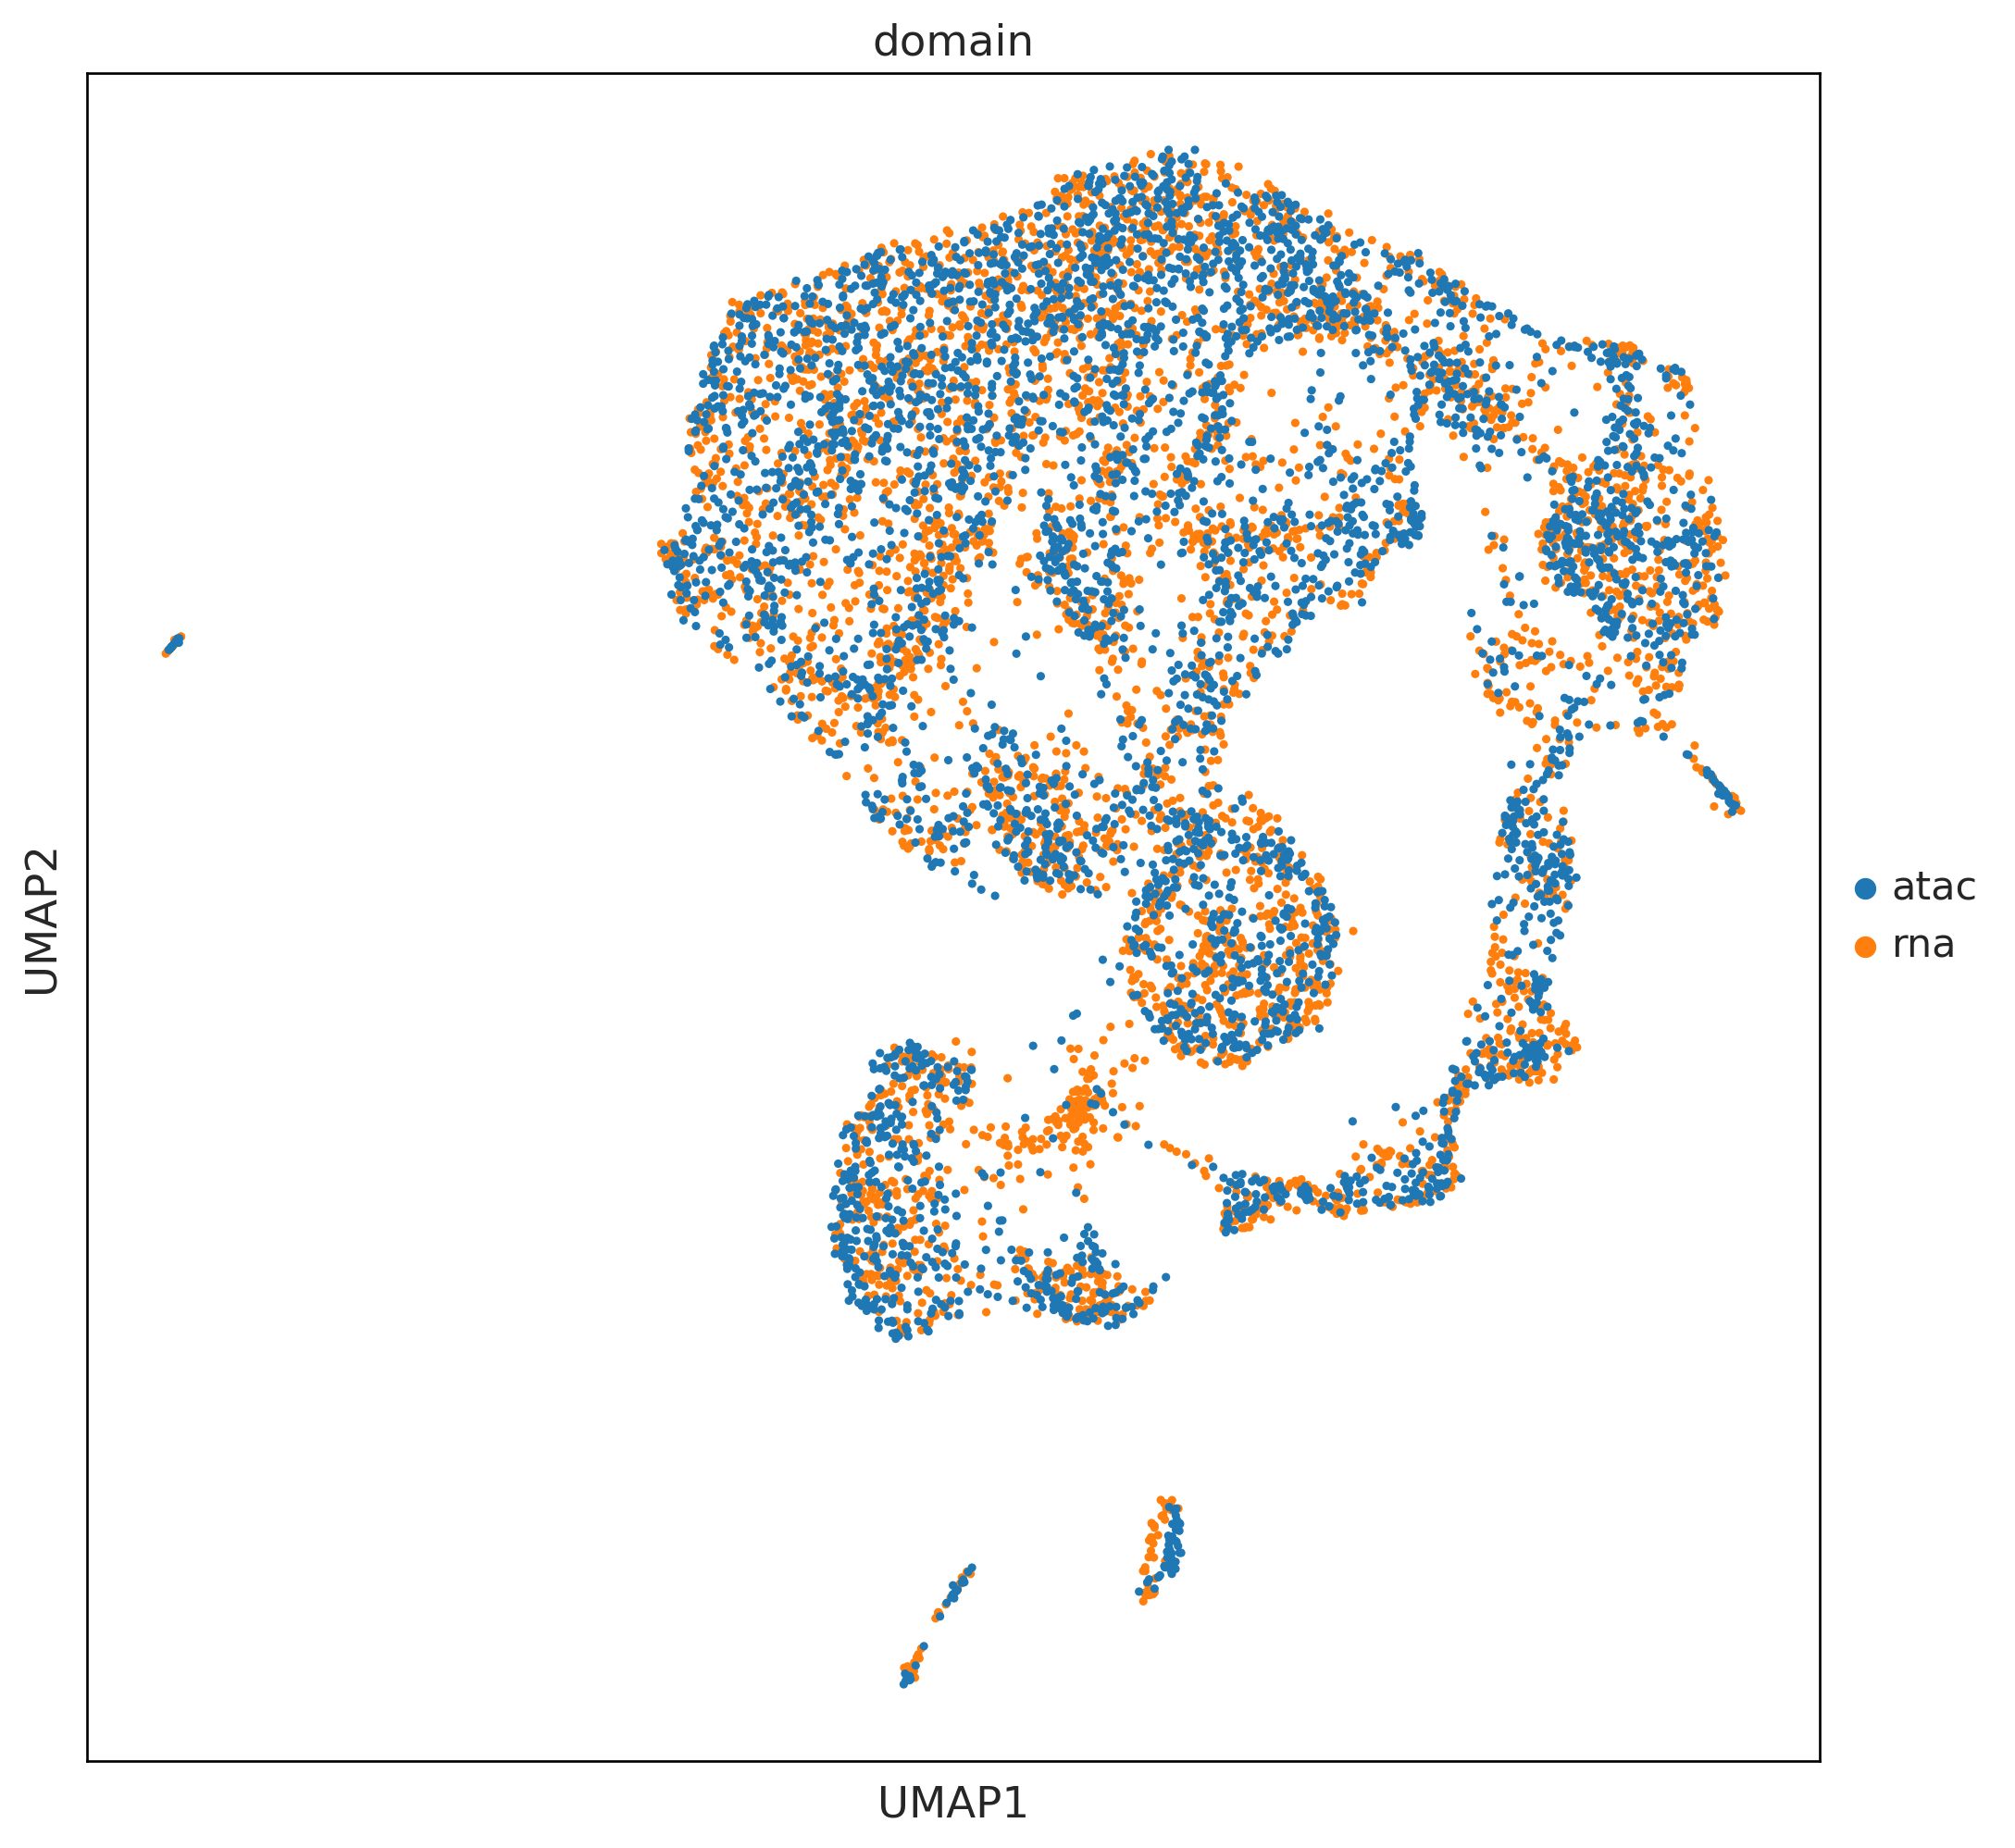

In [7]:
sc.pl.umap(combined, color=["domain"],s=30)

In [9]:
data_umap = combined.obsm['X_umap']
metadata = pd.DataFrame({'umap_x': data_umap[:,0],
                         'umap_y':data_umap[:,1],
                         'Label': combined.obs['SEACell_id'],
                         'domain': combined.obs['domain']})

metadata = metadata.sort_values(['Label'])
metadata['Label'] = metadata['Label'].astype(str)

In [28]:
metacells = np.unique(atac.obs[atac.obs.SEACell_id.isin(to_keep.astype(int))].SEACell)
metadata_metacells = metadata.loc[metacells]

In [25]:
metadata_metacells

umap_x     umap_y Label domain
index                                                
AGTCGCATCAGTGAAG-1  16.482515   4.763716    14    rna
AGTCGCATCAGTGAAG-1  17.328331   6.419021    14   atac
CAAACACTCACTTCAT-1   6.758573  14.747454    18    rna
CAAACACTCACTTCAT-1   6.599061  15.629106    18   atac
GATTGCGTCTGTAATG-1  10.373599  -4.916739    31   atac
GATTGCGTCTGTAATG-1  10.382075  -4.058213    31    rna
TGACTTAAGCATGCAT-1  10.999881   8.521463    49   atac
TGACTTAAGCATGCAT-1  10.647277   8.415145    49    rna
TGAGCTTAGAACCTGT-1  15.766788  13.729570    50    rna
TGAGCTTAGAACCTGT-1  15.123183  14.233333    50   atac

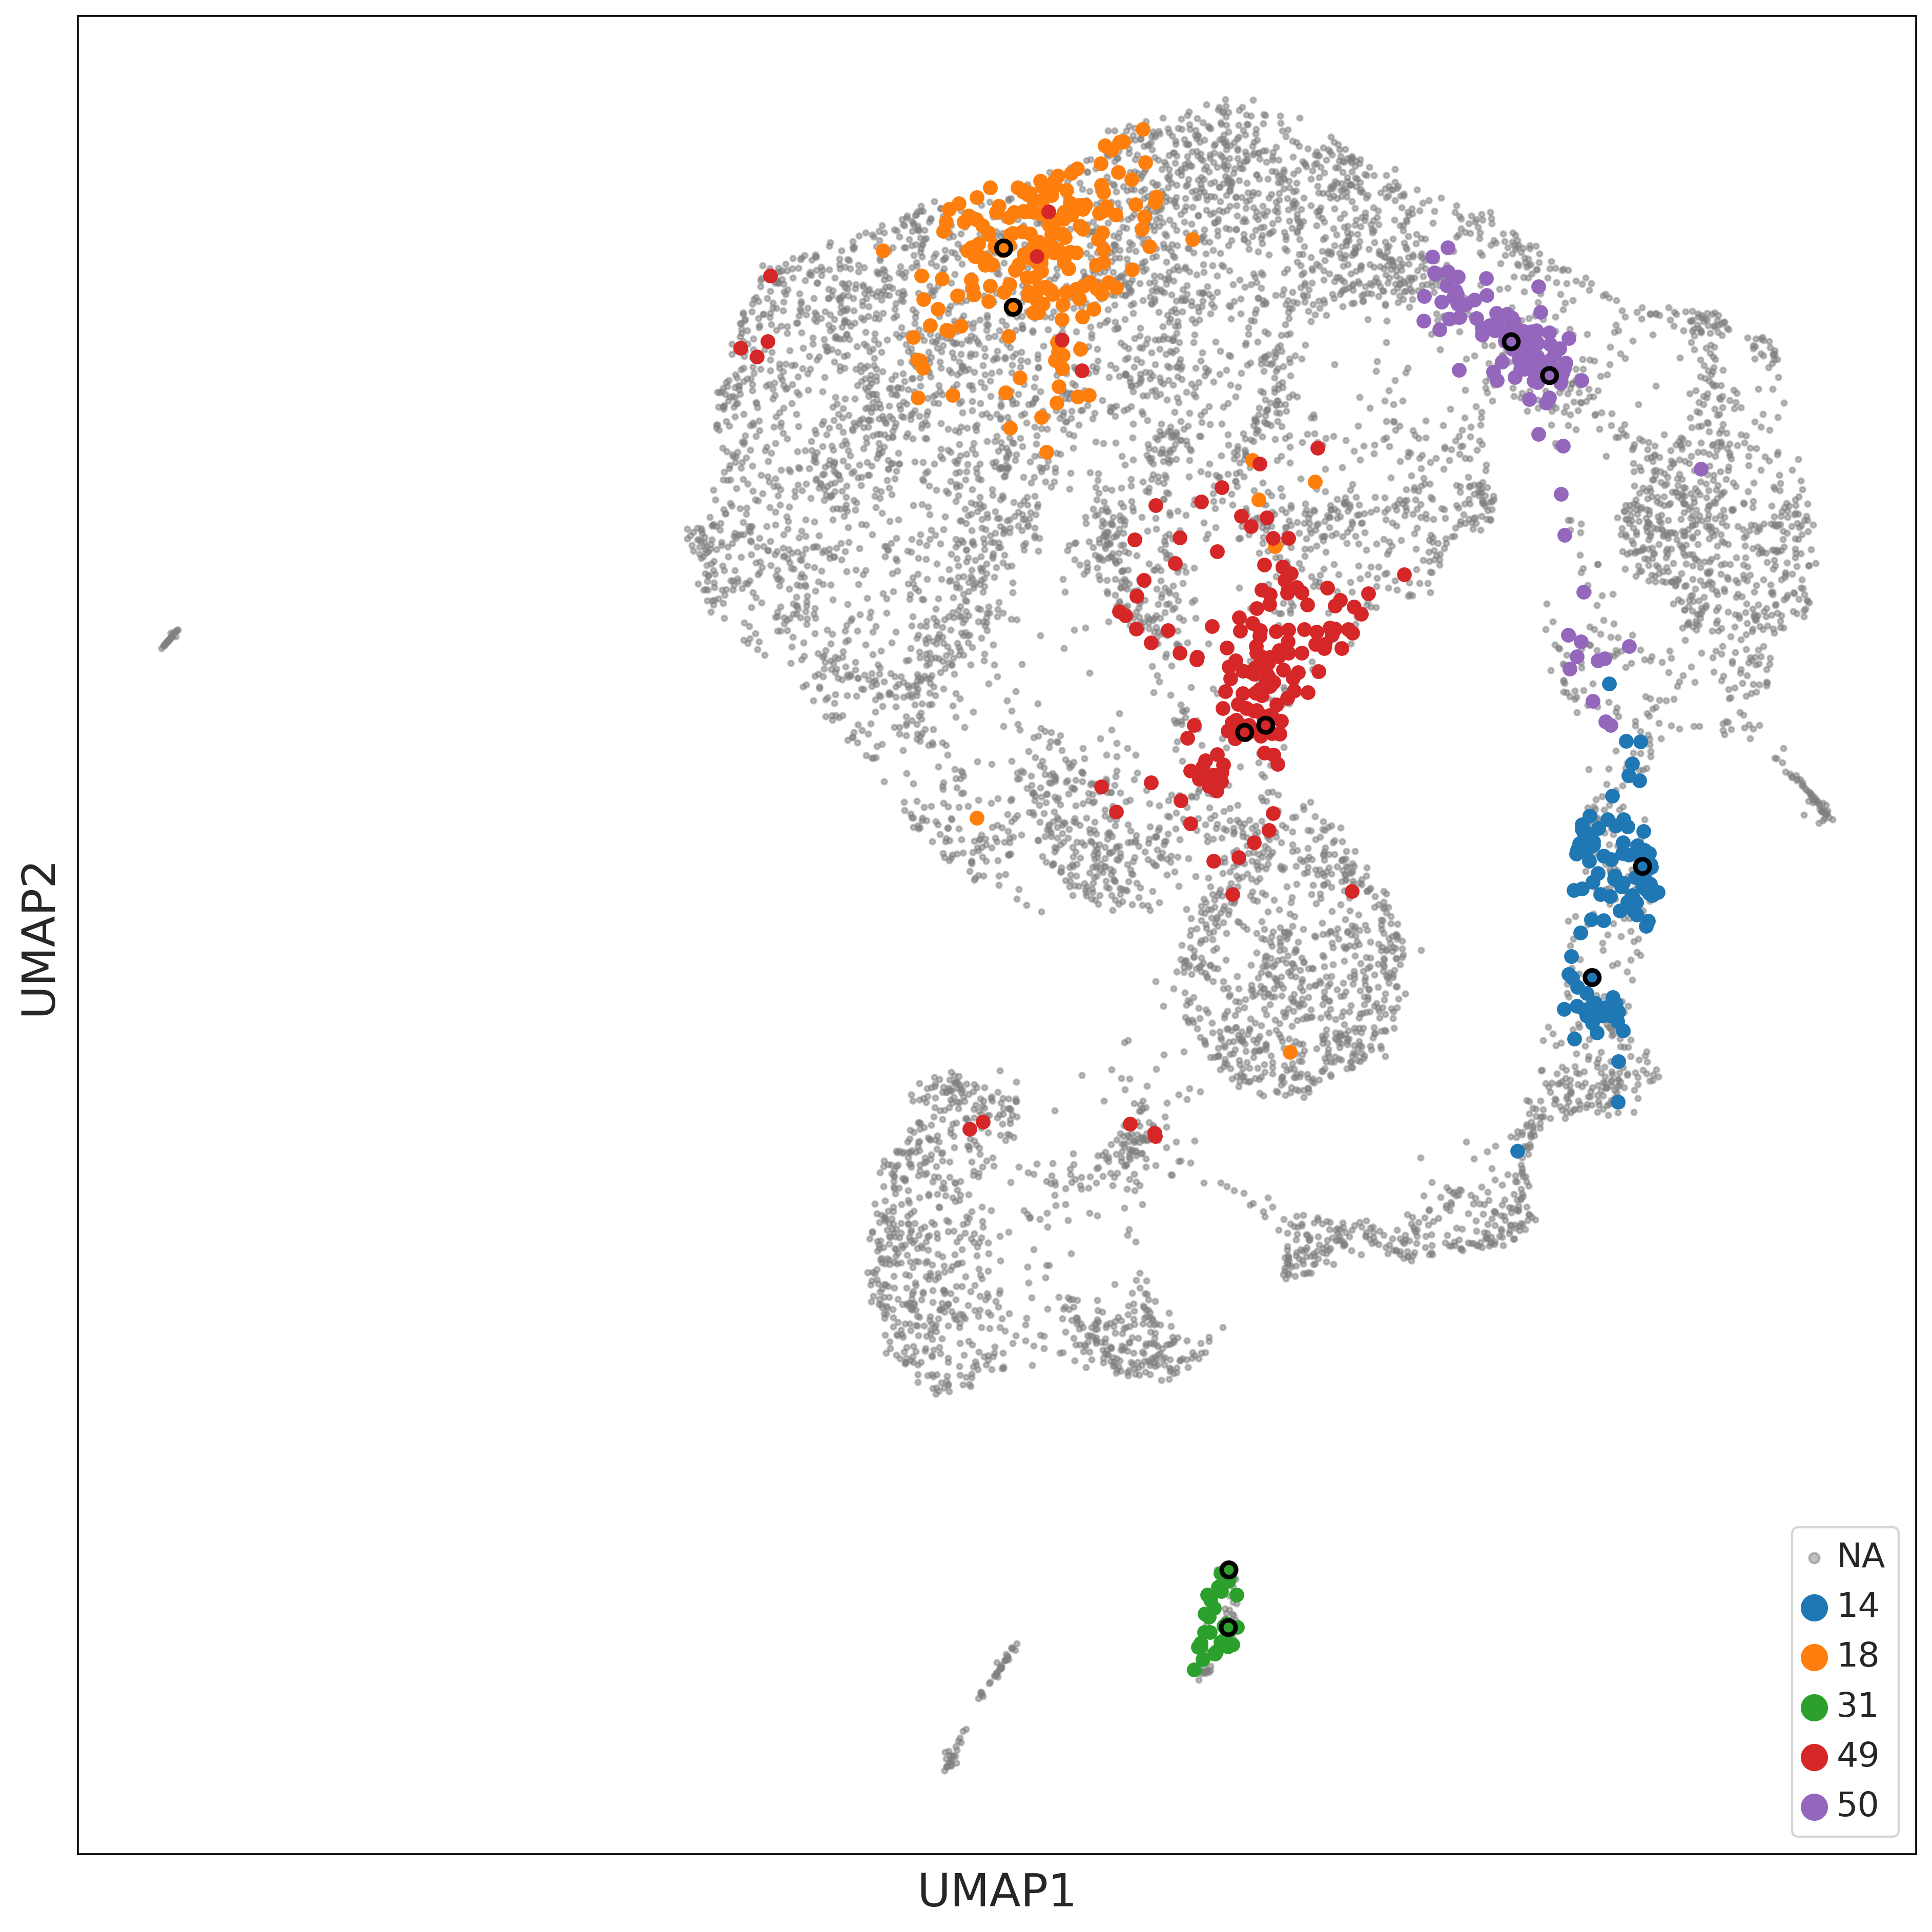

In [42]:
to_keep = np.array(['14','18','31','49','50'])
colors = cycle(cm.get_cmap('tab10').colors)
fig, ax1 = plt.subplots(1, 1)
metadata_rest = metadata[~metadata['Label'].isin(to_keep)]
ax1.scatter(metadata_rest['umap_x'],
            metadata_rest['umap_y'],
            color=(0.5, 0.5, 0.5),
            s=5,
            alpha=0.5)

for lab,col in zip(to_keep,colors):
    metadata_interest = metadata[metadata['Label']==lab]
    scatter = ax1.scatter(metadata_interest['umap_x'],
                metadata_interest['umap_y'],
                s=30,
                color = col,
                cmap='tab10');
    
metacells = np.unique(atac.obs[atac.obs.SEACell_id.isin(to_keep.astype(int))].SEACell)
metadata_metacells = metadata.loc[metacells]

ax1.scatter(metadata_metacells['umap_x'],
            metadata_metacells['umap_y'],
            facecolors='none',
            edgecolors='k',
            linewidth=2,
            s=40,
            alpha=1,
            marker='o')

ax1.legend(np.concatenate([['NA'],to_keep]),
          loc='lower right',
          fontsize=15,
          markerscale=2)
    

ax1.set_title('')
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])
ax1.set_xlabel('UMAP1',fontsize=20)
ax1.set_ylabel('UMAP2',fontsize=20)
#ax1.axis('off')
fig.set_size_inches(12,12)
fig.set_dpi(160)
plt.tight_layout()

In [96]:
free = np.random.normal(60,20,1000)
mono = np.random.normal(180,30,800)
poly = np.random.normal(350,50,300)
plot = np.concatenate([free,mono,poly])
plt.figure(figsize=(6,6,))
sns.displot(plot,kind='kde',ax=ax)

## Sampled metacells in a "spatial domain"

In [88]:
def plot_spatial(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=1):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = int(np.ceil((n_cell_types+1) / nrows))
    for i,ct in enumerate(range(n_cell_types)):
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax[i]
                  )
        plt.colorbar()
        if len(names) > 1:
            plt.title(names[ct])
        else:
            plt.title(f'{names[0]} {ct+1}')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.colorbar()
    plt.title('total')

In [3]:
path = '/lustre/scratch/kiviaho/spatac/integrations/multiome_5k/metacells_5_cells_per_spot_10/results/'
os.chdir(path)

# DOWNLOAD DATA
rna = sc.read_h5ad('rna-20221121-with-glue-embeddings.h5ad')
atac = sc.read_h5ad('atac-20221121-with-glue-embeddings.h5ad')
glue = scglue.models.load_model('glue-model-20221121.dill')

# Add common column key to plot with
rna.obs['domain'] = 'rna'
atac.obs['domain'] = 'atac'

rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

[INFO] autodevice: Using CPU as computation device.


In [48]:

combined = ad.concat([rna, atac])

sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)


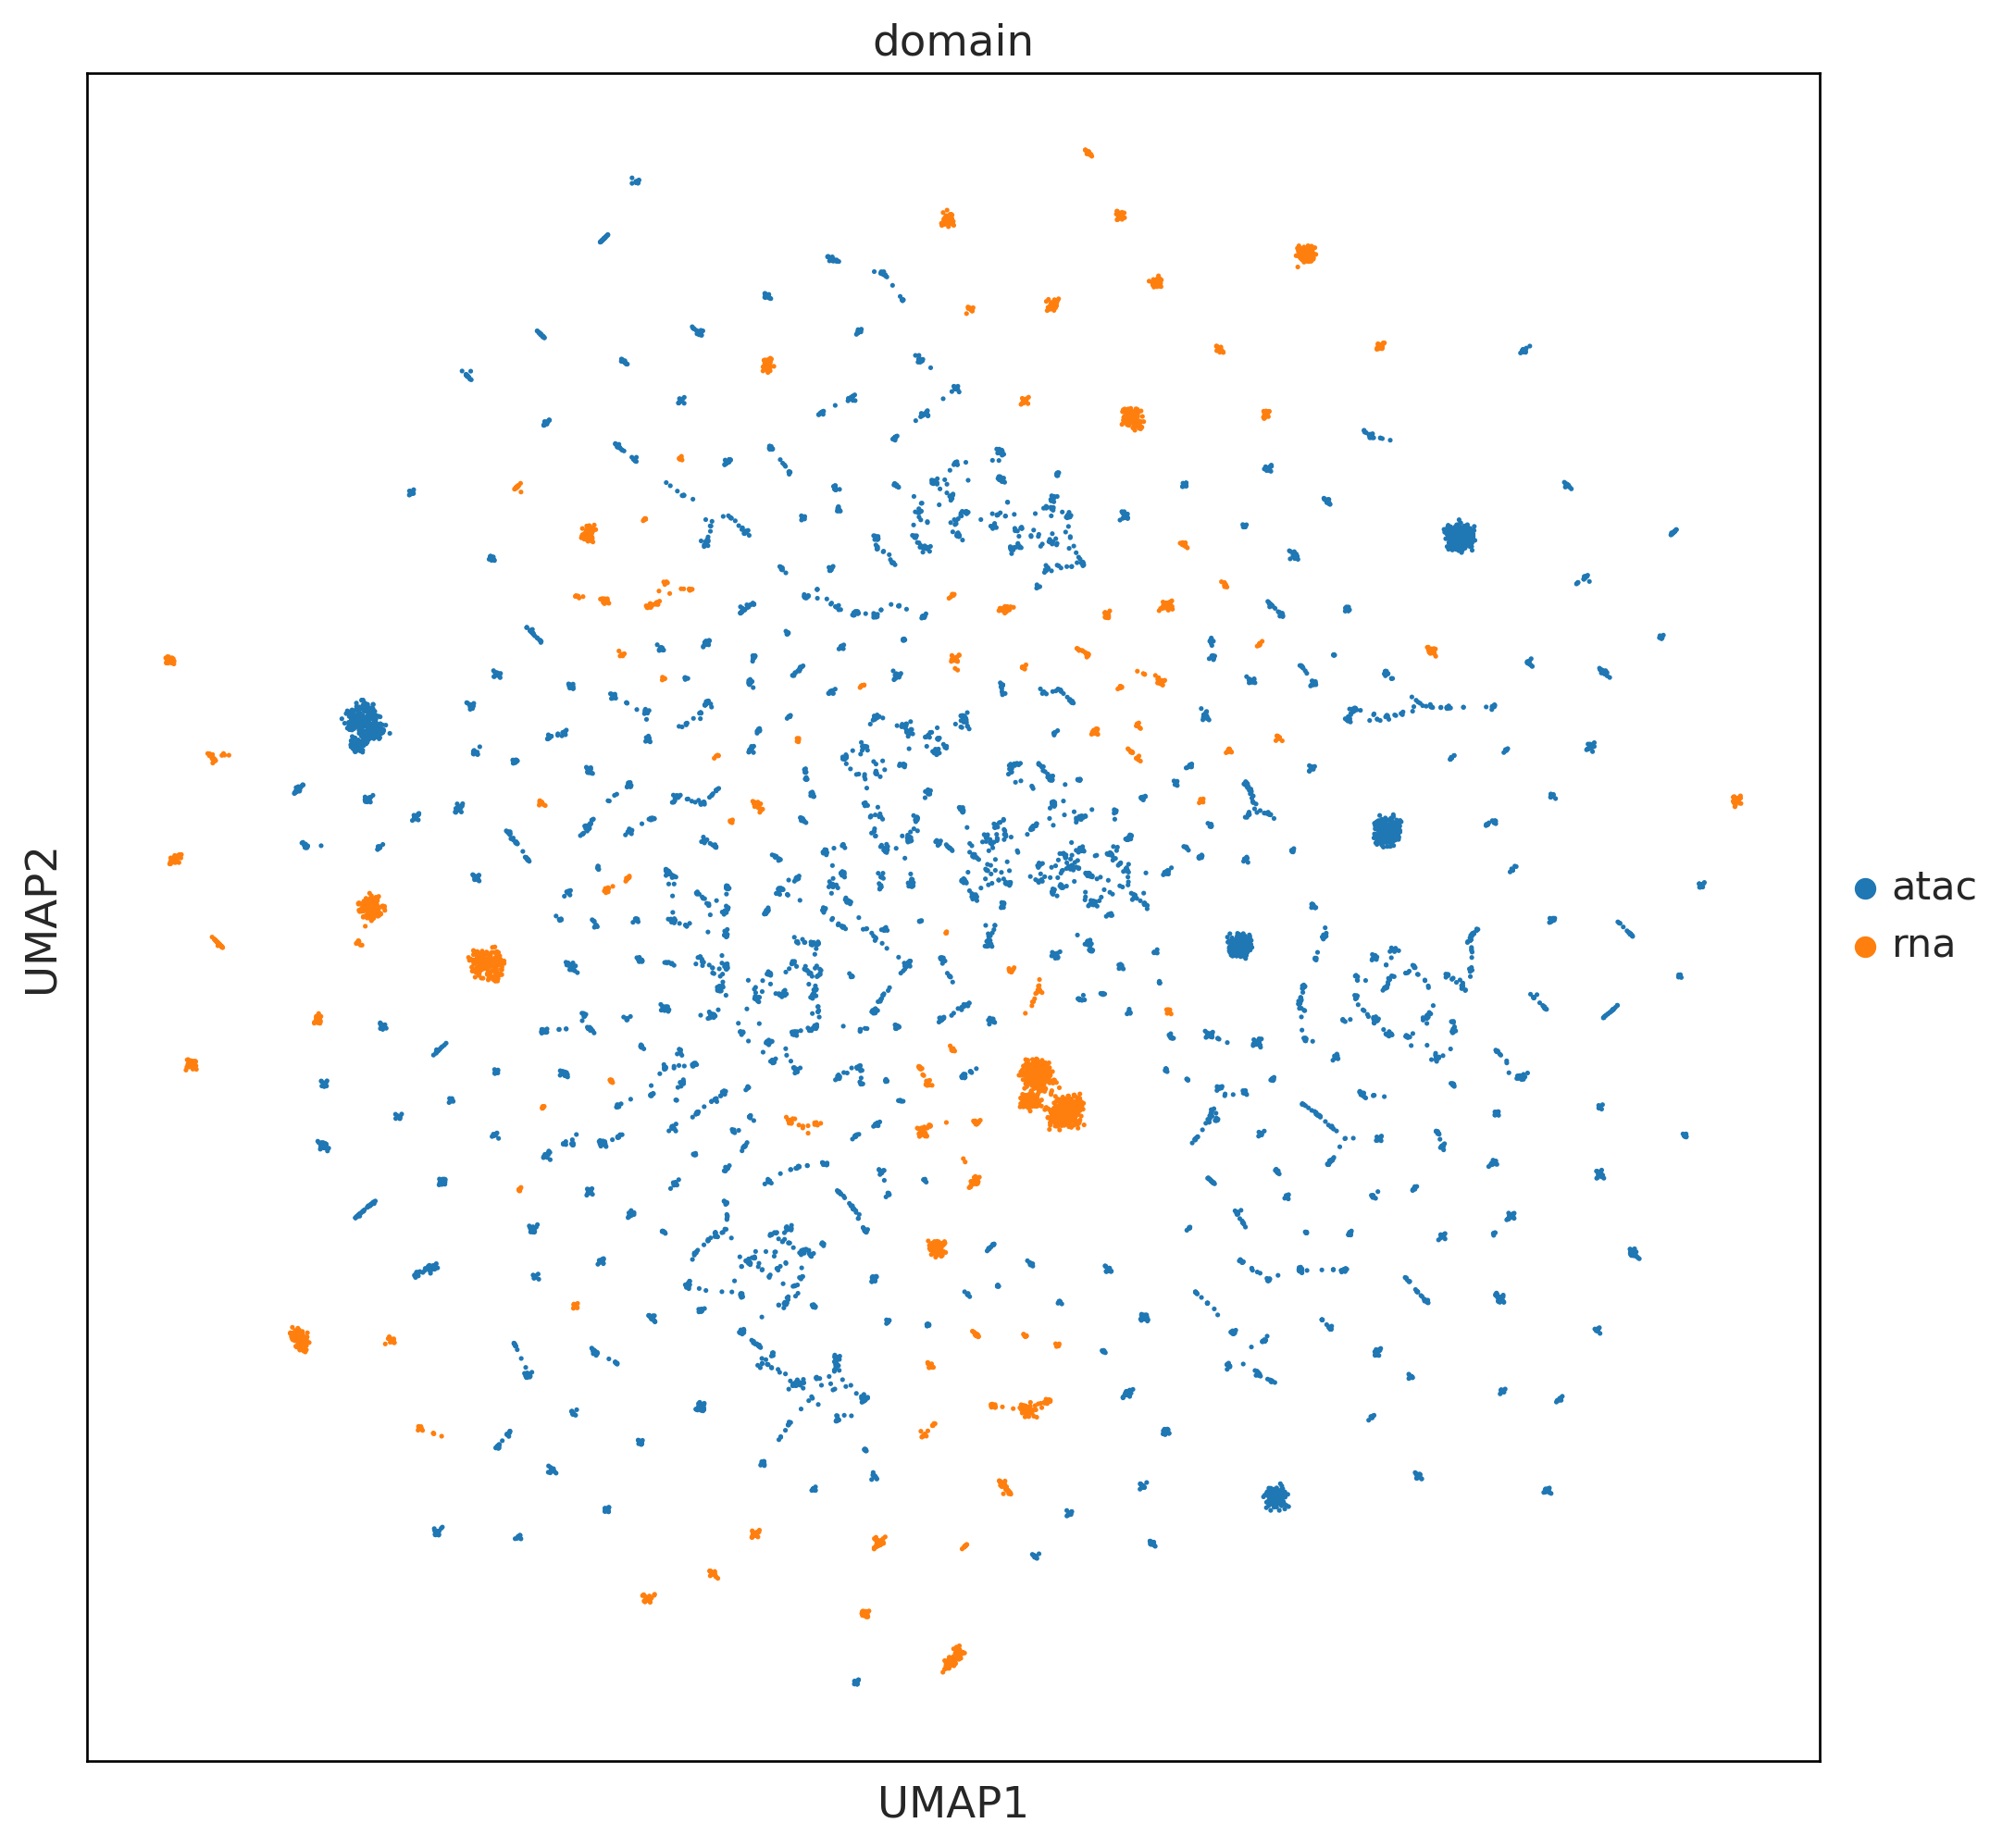

In [49]:
sc.pl.umap(combined, color=["domain"])

In [44]:
import time
n_neighbors = 10

start = time.time()
rna_glue = rna.obsm['X_glue']
atac_glue = atac.obsm['X_glue']

inferred_counts = np.empty((0,6),dtype=float)

for a_idx in range(len(rna_glue)):
    distances = []
    a = rna_glue[a_idx]
    # Calculate the euclidean distance in GLUE space between each 'spot'
    for b_idx in range(len(atac_glue)):
        b = atac_glue[b_idx]
        distances.append(np.linalg.norm(a-b))

    # Extract indices of n nearest matches
    nearest_matches = np.array(distances).argsort()[:n_neighbors]

    # Extract the cell counts and calculate their mean
    inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])
time.time() - start

/tmp/ipykernel_21226/1246952789.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean()).astype(int)])


315.4272999763489

In [99]:
inferred_spot_cell_counts = pd.DataFrame(inferred_counts, 
                             columns=rna.obs.columns[:inferred_counts.shape[1]],
                             index=rna.obs.index)
inferred_spot_cell_counts.drop(columns=['balancing_weight'],inplace=True)
cell_count_df = rna.obs.iloc[:,0:5]

In [116]:
cell_type = '49'
np.abs(inferred_spot_cell_counts[cell_type]-cell_count_df[cell_type]).mean()

1.093611111111111

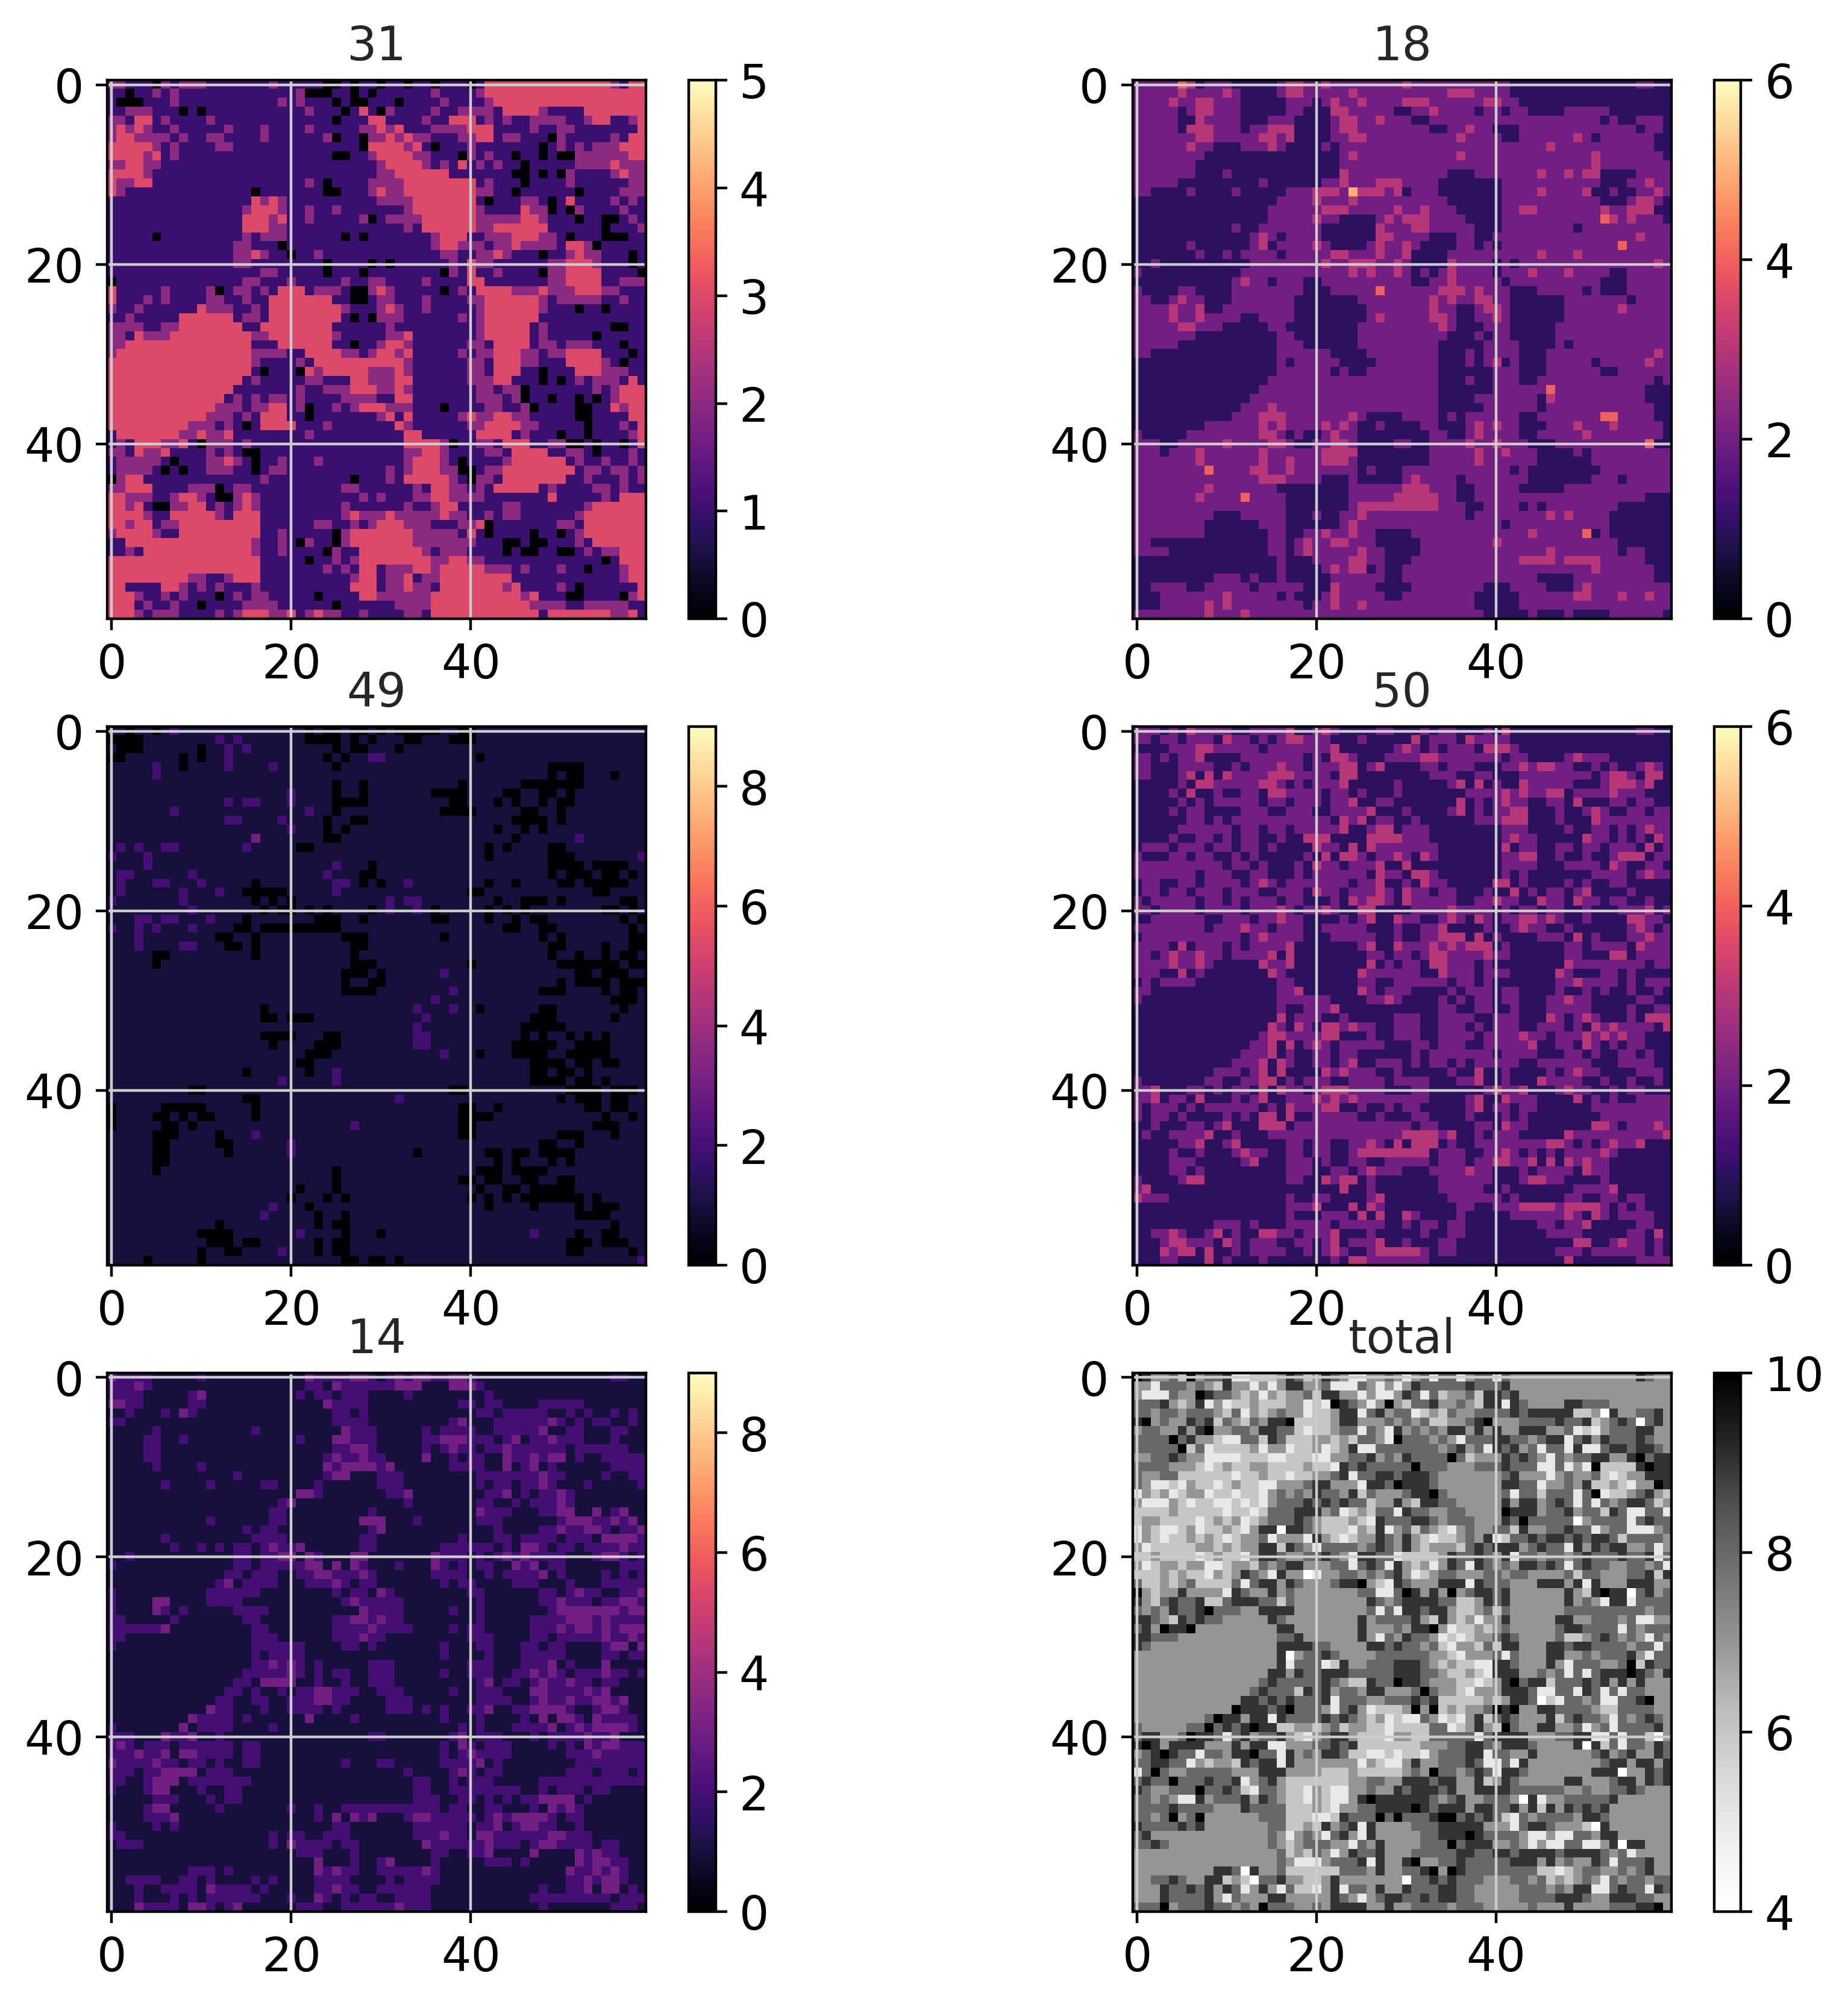

In [98]:
n_locations = [60, 60]
plt.figure(figsize=(10,10),dpi=200)
plot_spatial(inferred_spot_cell_counts.values, 
             n=n_locations, nrows=3, 
             names=inferred_spot_cell_counts.columns, vmax=[5,6,9,6,9,13])

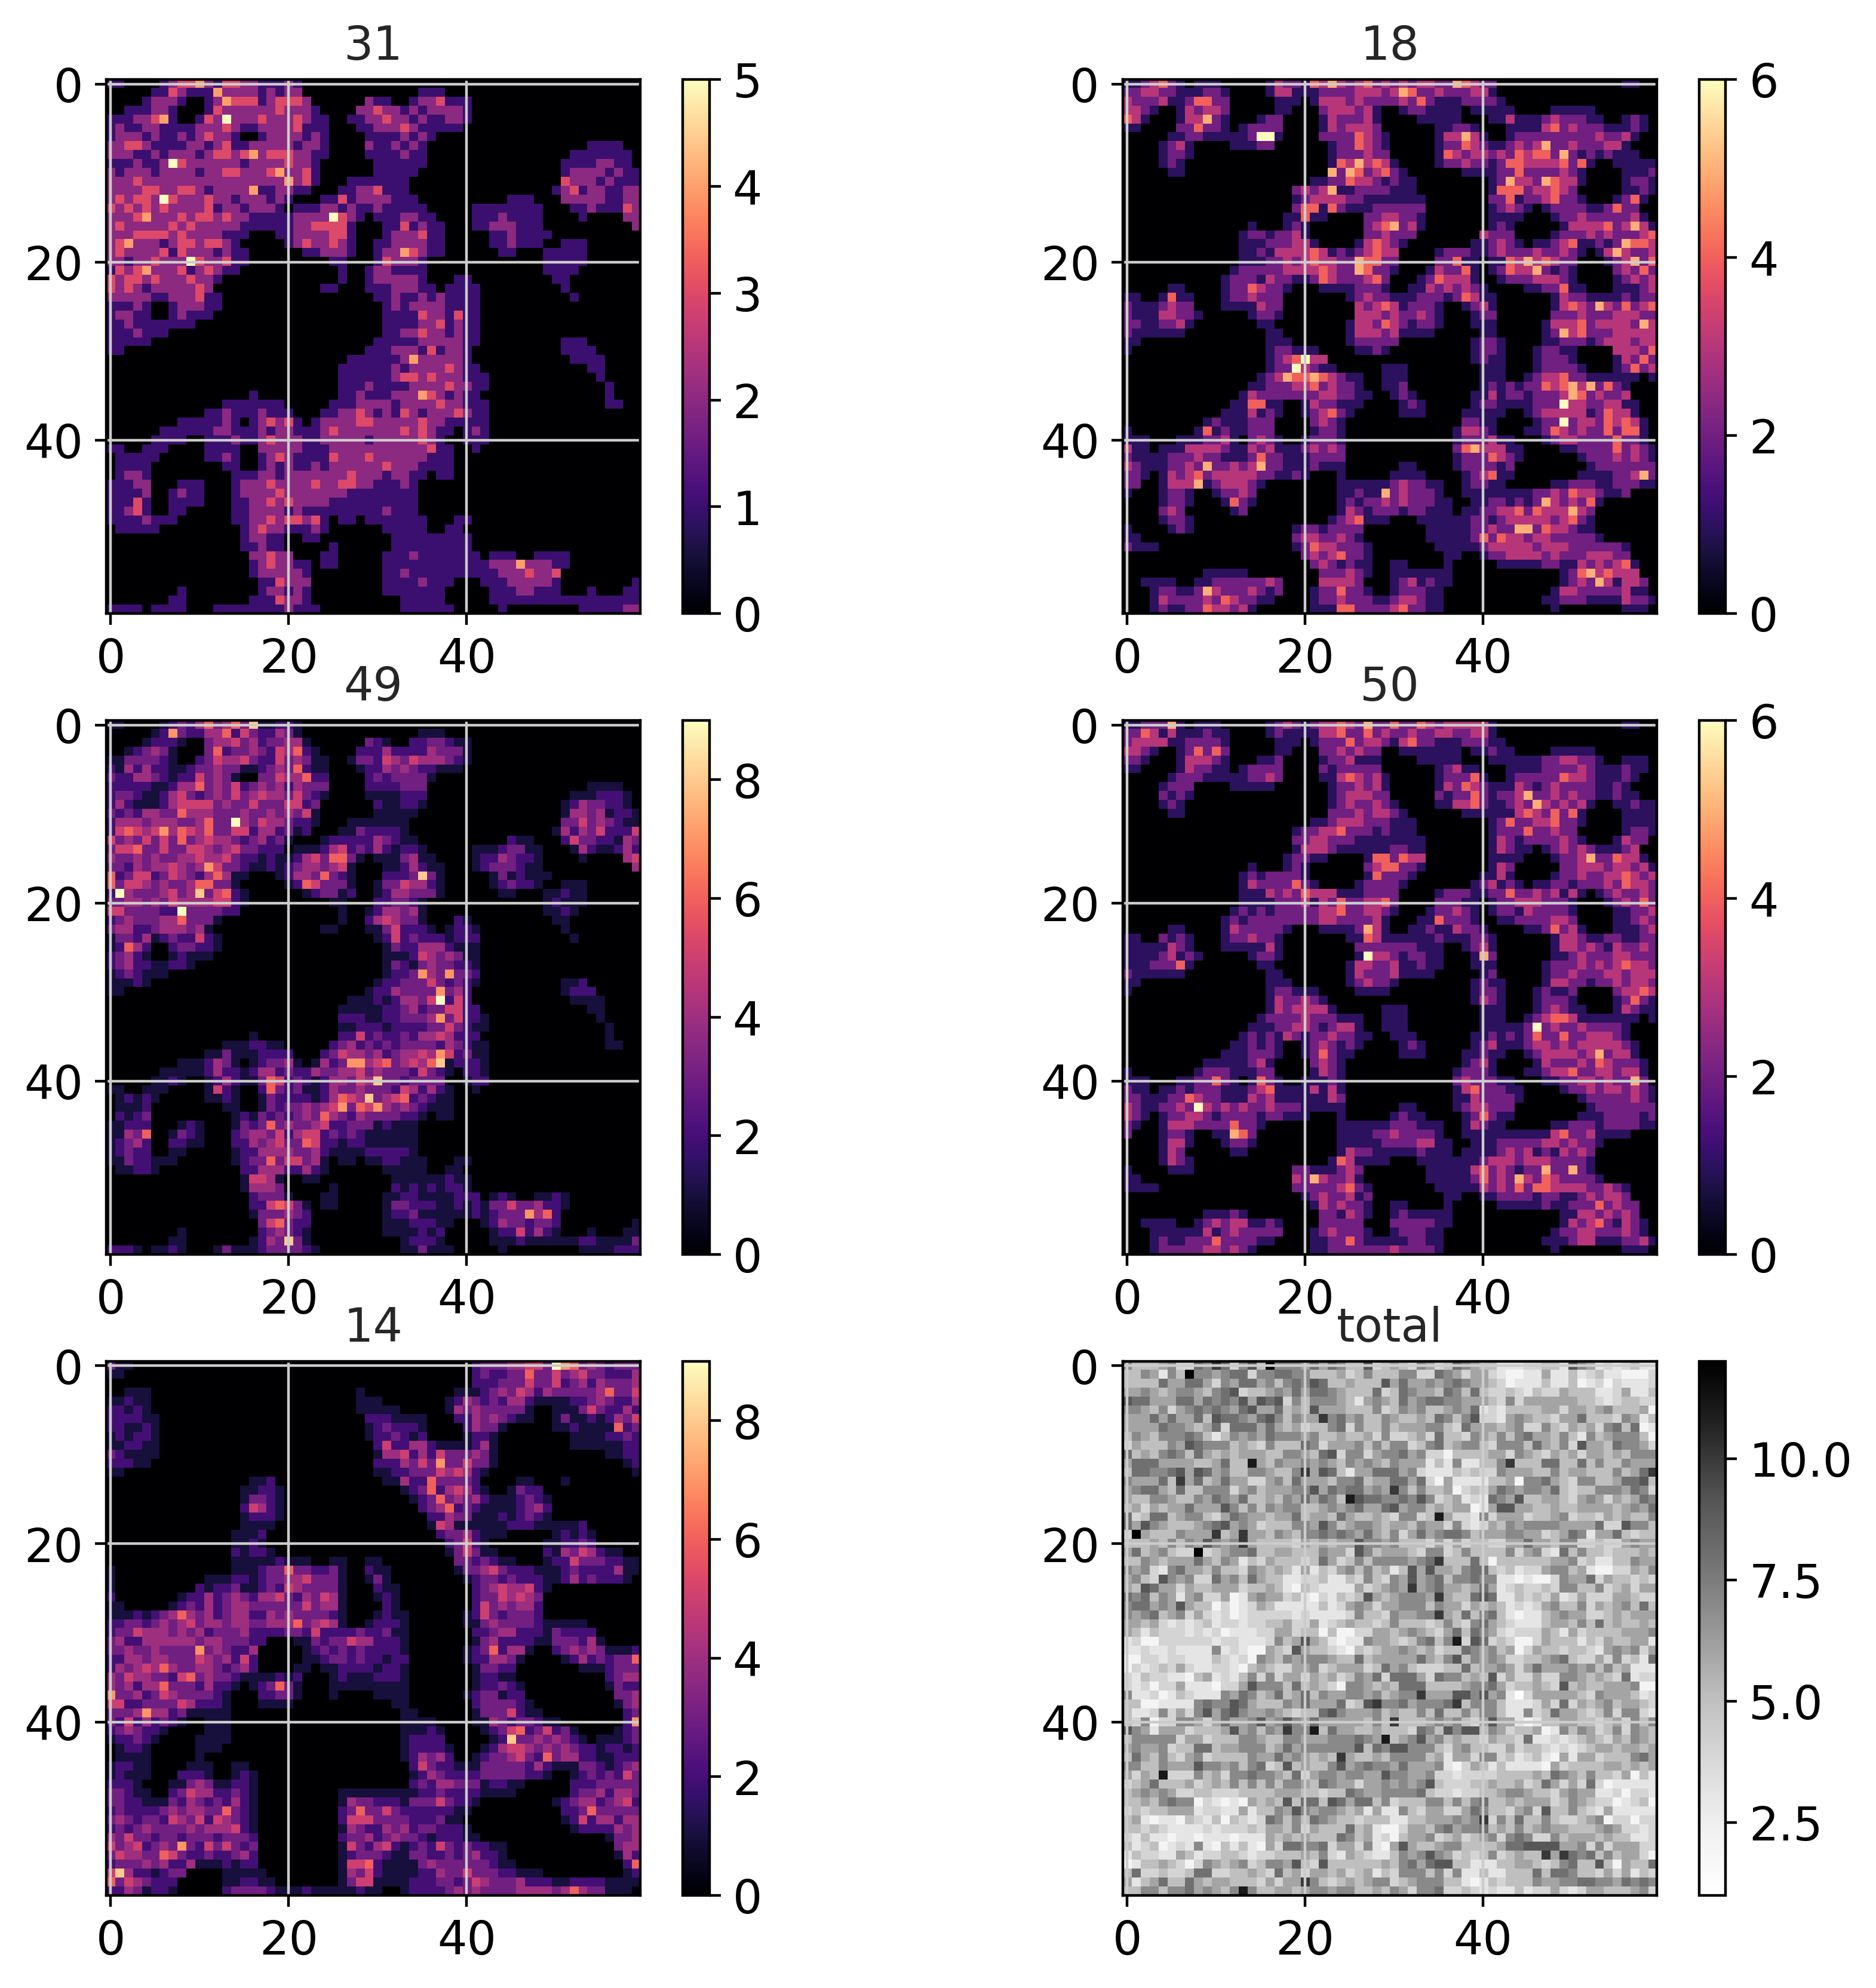

In [90]:

n_locations = [60, 60]
plt.figure(figsize=(10,10),dpi=200)
plot_spatial(cell_count_df.values, 
             n=n_locations, nrows=3, 
             names=cell_count_df.columns, vmax=np.repeat(None,cell_count_df.shape[1]))

## Integration done with individual cells

In [117]:
path = '/lustre/scratch/kiviaho/spatac/integrations/multiome_5k/individual_cells_per_spot_10_from_5_metacells/results/'
os.chdir(path)

# DOWNLOAD DATA
rna = sc.read_h5ad('rna-20221121-with-glue-embeddings.h5ad')
atac = sc.read_h5ad('atac-20221121-with-glue-embeddings.h5ad')
glue = scglue.models.load_model('glue-model-20221121.dill')

# Add common column key to plot with
rna.obs['domain'] = 'rna'
atac.obs['domain'] = 'atac'

rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)


combined = ad.concat([rna, atac])

sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)


In [118]:
import time
n_neighbors = 10

start = time.time()
rna_glue = rna.obsm['X_glue']
atac_glue = atac.obsm['X_glue']

inferred_counts = np.empty((0,6),dtype=float)

for a_idx in range(len(rna_glue)):
    distances = []
    a = rna_glue[a_idx]
    # Calculate the euclidean distance in GLUE space between each 'spot'
    for b_idx in range(len(atac_glue)):
        b = atac_glue[b_idx]
        distances.append(np.linalg.norm(a-b))

    # Extract indices of n nearest matches
    nearest_matches = np.array(distances).argsort()[:n_neighbors]

    # Extract the cell counts and calculate their mean
    inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])
time.time() - start

/tmp/ipykernel_21226/3905317158.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])


330.1871027946472

In [119]:
inferred_spot_cell_counts = pd.DataFrame(inferred_counts, 
                             columns=rna.obs.columns[:inferred_counts.shape[1]],
                             index=rna.obs.index)
inferred_spot_cell_counts.drop(columns=['balancing_weight'],inplace=True)
cell_count_df = rna.obs.iloc[:,0:5]

In [125]:
cell_type = '14'
np.abs(inferred_spot_cell_counts[cell_type]-cell_count_df[cell_type]).mean()

0.947666666666665

In [ ]:
n_locations = [60, 60]
plt.figure(figsize=(10,10),dpi=200)
plot_spatial(inferred_spot_cell_counts.values, 
             n=n_locations, nrows=3, 
             names=inferred_spot_cell_counts.columns, vmax=[5,6,9,6,9,13])

In [ ]:
n_locations = [60, 60]
plt.figure(figsize=(10,10),dpi=200)
plot_spatial(cell_count_df.values, 
             n=n_locations, nrows=3, 
             names=cell_count_df.columns, vmax=[5,6,9,6,9,13])